<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/BulkAnalyze_ljungbox_empiricalanddirect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import os
import statsmodels.stats.diagnostic as diag

def get_normalized_power_spectrum_welch(signal, nperseg):
  freqs, ps = scipy.signal.welch(
    signal, nperseg=nperseg, window='boxcar', detrend=False)
  #due to the symmetry property of the fourier transform for real-valued signals,
  # certain frequencies in the power spectrum
  # for real inputs have their power doubled. But we are interested in how the power
  # spectrum differs from a uniform power spectrum, so we need to undo that
  # doubling. Reference: https://github.com/scipy/scipy/blob/686422c4f0a71be1b4258309590fd3e9de102e18/scipy/signal/_spectral_py.py#L1900
  if nperseg%2: #if nperseg is odd
    ps[1:] /= 2
  else:
    ps[1:-1] /= 2
  return freqs, ps/np.sum(ps)

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = arr_cumsum[windowsize:] - arr_cumsum[:-windowsize]
  return smooth_arr/windowsize

def get_smoothed_arrs(arrs, windowsize):
  arr_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  smooth_arr = arr_cumsum[:,windowsize:] - arr_cumsum[:,:-windowsize]
  return smooth_arr/windowsize

def ljungbox_lag1(values):
  values = values - np.mean(values) #demean
  var = np.sum(values*values)/len(values)
  acf = np.sum(values[1:]*values[:-1])/(len(values)*var)
  sacf2 = acf**2/(len(values) - 1)
  qljungbox = len(values)*(len(values)+2)*sacf2

  return qljungbox, scipy.stats.chi2.sf(qljungbox, 1)

def ljungboxq_lag1_manyvals(values_2darr):
  values_2darr = values_2darr - np.mean(values_2darr, axis=1)[:,None]
  vars = np.sum(values_2darr*values_2darr, axis=1)/values_2darr.shape[1]
  acfs = np.sum(values_2darr[:,1:]*values_2darr[:,:-1], axis=1)/(values_2darr.shape[1]*vars)
  sacfs2 = np.square(acfs)/(values_2darr.shape[1] - 1)
  qsljungbox = values_2darr.shape[1]*(values_2darr.shape[1]+2)*sacfs2

  return qsljungbox

def perform_powerspectrum_analysis(values, num_permutations):

  toreturndict = {}
  ljungbox_q, ljungbox_p = ljungbox_lag1(values)
  toreturndict['pval_direct_ljundbox'] = ljungbox_p

  rng = np.random.RandomState(1234)
  permuted_values_2darr = np.array([rng.permutation(values)
                              for i in range(num_permutations)])
  permuted_qsljungbox = ljungboxq_lag1_manyvals(permuted_values_2darr)
  pval_ljungbox_empirical = np.mean(ljungbox_q < permuted_qsljungbox)
  toreturndict['pval_empirical_ljundbox'] = pval_ljungbox_empirical

  return (toreturndict, (None, None))

  """for (nperseg, npersegname) in [(30*15, "7.5min"),
                                 (60*15, "15min"),
                                 (60*30, "30min"),
                                 (60*60, "60min"),
                                 (len(values), "NA")]:
    freqs, nps = get_normalized_power_spectrum_welch(values, nperseg)

    #freqs = np.fft.rfftfreq(len(values), 1)
    #rps = get_relative_power_spectrum(values)

    #permute the test data sequence num_permutations times to get an empirical null
    rng = np.random.RandomState(1234)
    #rps_permute_2darr = np.array([get_relative_power_spectrum(rng.permutation(values))
    #                              for i in range(num_permutations)])
    nps_permute_2darr = np.array([
        get_normalized_power_spectrum_welch(rng.permutation(values), nperseg)[1]
        for i in range(num_permutations)])

    uniform_expectation = 1.0/len(nps)

    expected_freq = np.sum(freqs*nps)
    expected_freq_permute_arr = np.sum(freqs[None,:]*nps_permute_2darr, axis=1)
    pval_ef = np.sum(expected_freq_permute_arr >= expected_freq)/len(expected_freq_permute_arr)

    maxd = np.max(np.abs(np.cumsum(nps - uniform_expectation)))
    maxd_permute_arr = np.max(np.abs(np.cumsum(nps_permute_2darr - uniform_expectation, axis=1)), axis=1);
    pval_maxd = np.sum(maxd_permute_arr >= maxd)/len(maxd_permute_arr)

    smooth_pvals = {}
    peak_freqs = {} #just for information purposes
    freq_stepsize = freqs[1]
    smoothfreqwindows = [('p00625', 0.00625),
                        ('p0075', 0.0075),
                        ('p01', 0.01),
                        ('p0125', 0.0125),
                        ('p015', 0.015),
                        ('p02', 0.02),
                        ('p025', 0.025),
                        ('p05', 0.05)]
    for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
      windowsize = int(smoothfreqwindow/freq_stepsize)
      smooth_rps = get_smoothed_arr(nps, windowsize)
      smooth_xaxis = get_smoothed_arr(freqs, windowsize)
      argmax_smooth_rps = np.argmax(smooth_rps)
      max_smooth_rps = smooth_rps[argmax_smooth_rps]
      peak_freq = smooth_xaxis[argmax_smooth_rps]
      max_smooth_rps_permutetest_2darr = np.max(
        get_smoothed_arrs(nps_permute_2darr, windowsize), axis=1)
      pval_smooth = (np.sum(max_smooth_rps_permutetest_2darr
                     >= max_smooth_rps)/len(max_smooth_rps_permutetest_2darr))
      smooth_pvals[smoothfreqwindow] = pval_smooth
      peak_freqs[smoothfreqwindow] = peak_freq

    toreturndict['pval_nperseg-'+npersegname+'_ef'] = pval_ef
    toreturndict['pval_nperseg-'+npersegname+'_maxd'] = pval_maxd
    for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
      toreturndict['pval_nperseg-'+npersegname+'_smooth-'+smoothfreqname] = smooth_pvals[smoothfreqwindow]
    toreturndict['nperseg-'+npersegname+'_peakfreqs'] = peak_freqs

  return (toreturndict, (freqs, nps))"""


In [ ]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

def get_covarmetric(egg_values): #a better metric that actually gets at covariance
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  #derivation:
  # covariance looks at the product of (X - mu_X)(Y - mu_Y)
  # if X and Y are Z-normalized, mean is 0 and this becomes a product of Z scores
  # (Z1 + Z2 + Z3)^2 = Z1^2 + Z2^2 + Z3^2 + 2Z1Z2 + 2Z1Z3 + 2Z2Z3
  # ((Z1 + Z2 + Z3)^2 - (Z1^2 + Z2^2 + Z3^2))/2 = (Z1Z2 + Z1Z3 + Z2Z3)
  # The variance of the product of zero-mean independent samples is equal to the
  # product of their variances, so under the null each Z1Z2 has variance 1.
  # Also, variance of the sum of two independent rvs is the sum of their
  # variances, so we divide by sqrt(N*(N-1)/2) where N is the number of non-nan eggs, so
  # that the variance under the null hypothesis is the same for all rows.

  z_indiv_eggs = (egg_values - 100)/np.sqrt(50) #z scores for individual eggs
  sum_sq_z_indiv_eggs = np.nansum(np.square(z_indiv_eggs), axis=1)
  sq_sum_z_indiv_eggs = np.square(np.nansum(z_indiv_eggs, axis=1)) #sum z scores across eggs, square
  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1)
  covar_metric = (sq_sum_z_indiv_eggs - sum_sq_z_indiv_eggs)/(2*np.sqrt(num_nonnan_eggs*(num_nonnan_eggs-1)/2))

  return covar_metric

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [ ]:
event_metadata_list

[['Event391', 'Internat Day Peace', 0.0008192443394802185],
 ['Event289', 'Meditations Valentines Day', 0.002569859448349643],
 ['Event487', 'September 21', 0.003153268038066148],
 ['Event217', 'Indonesian Earthquake', 0.0032705236405630167],
 ['Event203', 'Baghdad Bridge Stampede', 0.007938503795130725],
 ['Event472', 'Mandela Dies', 0.008229306940944703],
 ['Event360', 'Brazilian Mudslides', 0.012434298335079697],
 ['Event266', 'Obama Wins Nomination', 0.014699315651582556],
 ['Event395', 'Steve Jobs Dies', 0.015513261511045151],
 ['Event341', 'Chilean Miners Alive', 0.0159787032720784],
 ['Event199', 'Oraworld Resonance', 0.016077254762331683],
 ['Event437', 'Dr. Tomorrow Passes', 0.01899878662499621],
 ['Event413', 'Mogadishu Bombing', 0.01933102456739566],
 ['Event56', 'Pierre Trudeau Funeral', 0.021572192676071245],
 ['Event205', 'Bali Bombing 2', 0.022006592782255807],
 ['Event324', 'Health Care is Law', 0.02369816101463118],
 ['Event272', 'Palin Acceptance 080903', 0.0239297717

In [ ]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

csm1_zscores = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}
covarmetric_zscores = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

pvals_csm1 = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}
pvals_covarmetric = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

event_count = 0

dont_rerun_if_file_exists = False
savefolder = "/content/drive/MyDrive/GCP_data/analysis/indiv_events_ljundbox"

for (event, event_name, pval) in event_metadata_list[:100]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)
    covarmetric = get_covarmetric(egg_values)

    #for each of the csm1 and covarmetric scores, we will sum across the
    # duration. Since the events are at least an hour long, this will
    # be a sum of at least 3600 random variables with mean 0 and variance
    # 2 (for csm1) and 1 (for covarmetric),
    # that are iid under the null hypothesis. By the central limit theorem,
    # their sum should be Gaussian with mean 0 and variance = len(timeseries)
    # Dividing by sqrt(len(timeseries)) yields a Z score.
    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1))
    covarmetric_zscore = np.sum(covarmetric)/np.sqrt(len(covarmetric))
    print(spanname,"csm1 z score       :", csm1_zscore)
    print(spanname,"covarmetric z score:", covarmetric_zscore)
    csm1_zscores[spanname].append(csm1_zscore)
    covarmetric_zscores[spanname].append(covarmetric_zscore)

    #plot csm1 vals for context
    #%matplotlib inline
    #plt.figure(figsize=(10,2))
    #plt.plot(np.cumsum(csm1))
    #plt.show()

    for signaltype,signal,signalsavedict in [("csm1", csm1, pvals_csm1),
                                             ("covarmetric", covarmetric, pvals_covarmetric)]:
      outfile = savefolder+"/nperm"+str(NUM_PERMUTATIONS)+"_"+event+"_"+spanname+"_"+signaltype+"_analysissummary.json"
      if (dont_rerun_if_file_exists and os.path.isfile(outfile)):
        pvals = json.load(open(outfile))
      else:
        pvals, _ = perform_powerspectrum_analysis(signal, NUM_PERMUTATIONS)
        open(outfile, 'w').write(json.dumps(pvals, indent=4))
      print(signaltype, pvals)
      signalsavedict[spanname].append(pvals)


/content/drive/MyDrive/GCP_data

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
span: test
test csm1 z score       : 3.148966694327055
test covarmetric z score: 3.058467044848556
csm1 {'pval_direct_ljundbox': 0.6419708469641867, 'pval_empirical_ljundbox': 0.614}
covarmetric {'pval_direct_ljundbox': 0.8351246627830499, 'pval_empirical_ljundbox': 0.821}
span: control1
control1 csm1 z score       : 0.6832212654517521
control1 covarmetric z score: 0.5206296565229517
csm1 {'pval_direct_ljundbox': 0.06808815926614353, 'pval_empirical_ljundbox': 0.078}
covarmetric {'pval_direct_ljundbox': 0.05839210774941276, 'pval_empirical_ljundbox': 0.067}
span: control2
control2 csm1 z score       : -1.659478481923689
control2 covarmetric z score: -1.511422767325096
csm1 {'pval_direct_ljundbox': 0.7317316509494665, 'pval_empirical_ljundbox': 0.734}
covarmetric {'pval_direct_ljundbox': 0.8869144206813406, 'pval_empirical_ljundbox': 0.894}

----------------

In [ ]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_withwelchsmooth"

#save the pvals
open("/content/drive/MyDrive/GCP_data/analysis/csm1_zscores.json", 'w').write(
     json.dumps(csm1_zscores, indent=4))
open("/content/drive/MyDrive/GCP_data/analysis/covarmetric_zscores.json", 'w').write(
     json.dumps(covarmetric_zscores, indent=4))
open(prefix+"_csm1.json","w").write(json.dumps(pvals_csm1, indent=4))
open(prefix+"_covarmetric.json","w").write(json.dumps(pvals_covarmetric, indent=4))

1400505

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [ ]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

def get_meta_pval(pvals):
  minpval = 1.0/NUM_PERMUTATIONS
  pvals = np.maximum(np.array(pvals), minpval)
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

In [ ]:
csm1_zscores = json.load(open("/content/drive/MyDrive/GCP_data/analysis/csm1_zscores.json"))
covarmetric_zscores = json.load(open("/content/drive/MyDrive/GCP_data/analysis/covarmetric_zscores.json"))

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_withwelchsmooth"

pvals_csm1 = json.load(open(prefix+"_csm1.json"))
pvals_covarmetric = json.load(open(prefix+"_covarmetric.json"))

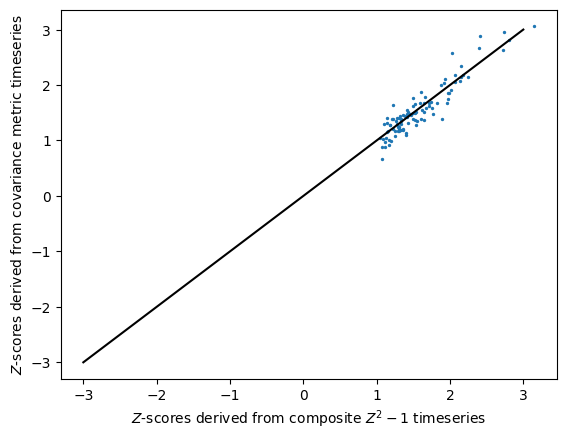

In [ ]:
%matplotlib inline
plt.scatter(csm1_zscores["test"], covarmetric_zscores["test"], s=2)
plt.xlabel("$Z$-scores derived from composite $Z^2 - 1$ timeseries")
plt.ylabel("$Z$-scores derived from covariance metric timeseries")
plt.plot([-3,3],[-3,3], color="black")
plt.show()

PearsonRResult(statistic=-0.12271368440096762, pvalue=0.2238661993261597)


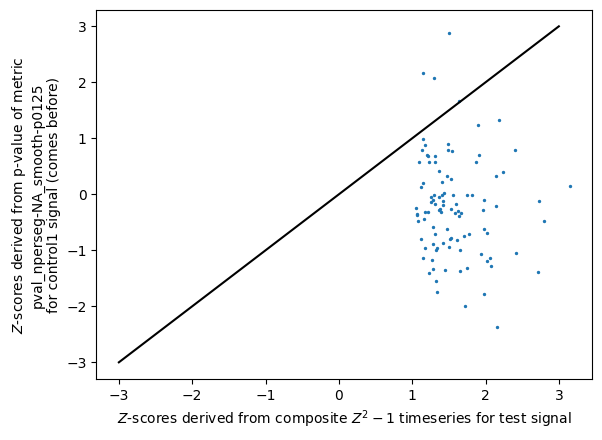

In [ ]:
import scipy

%matplotlib inline
plotmetricname = "pval_nperseg-NA_smooth-p0125"
xvals = csm1_zscores["test"]
yvals = [scipy.stats.norm().ppf(1-x[plotmetricname]) for x in pvals_csm1["control1"]]
print(scipy.stats.pearsonr(xvals, yvals))
plt.scatter(xvals, yvals, s=2)
plt.xlabel("$Z$-scores derived from composite $Z^2 - 1$ timeseries for test signal")
plt.ylabel("$Z$-scores derived from p-value of metric\n"+plotmetricname+"\nfor control1 signal (comes before)")
plt.plot([-3,3],[-3,3], color="black")
plt.show()

In [ ]:
import os

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([-np.log10(
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(pvals_csm1["test"])),
                  1.0/NUM_PERMUTATIONS)
      ) )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(pvals_csm1["test"]) #where to stop the plot

def make_meta_trend_plot(title, test_pvals, control1_pvals, control2_pvals, savefilename):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  #floor p values at the lowest detectable
  test_pvals, control1_pvals, control2_pvals = [
      np.maximum(arr, 1.0/NUM_PERMUTATIONS) for arr in
       [test_pvals, control1_pvals, control2_pvals]]

  test_metapvals = get_iterative_metapvals(test_pvals)
  control1_metapvals = get_iterative_metapvals(control1_pvals)
  control2_metapvals = get_iterative_metapvals(control2_pvals)

  theslice = slice(min_meta-1, max_meta)

  handles = []

  rng = np.random.RandomState(1234)

  maxsimmetapval_arr = np.max(simulated_metapvals_arr[:,theslice], axis=1) #the simulated meta pvals are already in -log10 space
  maxtestmetapval = np.max(-np.log10(test_metapvals[theslice]))
  maxcontrol1metapval = np.max(-np.log10(control1_metapvals[theslice]))
  maxcontrol2metapval = np.max(-np.log10(control2_metapvals[theslice]))

  minsimmetapval_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)
  mintestmetapval = np.min(-np.log10(test_metapvals[theslice]))
  mincontrol1metapval = np.min(-np.log10(control1_metapvals[theslice]))
  mincontrol2metapval = np.min(-np.log10(control2_metapvals[theslice]))

  print("Testing for postive z-scores:")
  print("test pval:", np.sum(maxtestmetapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control1 pval:", np.sum(maxcontrol1metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control2 pval:", np.sum(maxcontrol2metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))

  print("Testing for negative z-scores:")
  print("test pval:", np.sum(mintestmetapval > minsimmetapval_arr)/len(minsimmetapval_arr))
  print("control1 pval:", np.sum(mincontrol1metapval > minsimmetapval_arr)/len(minsimmetapval_arr))
  print("control2 pval:", np.sum(mincontrol2metapval > minsimmetapval_arr)/len(minsimmetapval_arr))

  matplotlib.use('agg')
  fig = plt.figure(figsize=(20,4))
  for simulated_metapvals in simulated_metapvals_arr:
    plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-np.power(10,-simulated_metapvals[theslice])), color="orange", alpha=0.003)

  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-test_pvals[:max_meta]), color="blue", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control1_pvals[:max_meta]), color="green", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control2_pvals[:max_meta]), color="red", s=2)

  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-test_metapvals[theslice]), color="blue")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control1_metapvals[theslice]), color="green")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control2_metapvals[theslice]), color="red")

  plt.plot([min(xaxis_full), max(xaxis_full)],
           [0, 0],
           color="black", linestyle="--")
  plt.plot(xaxis_full, csm1_zscores["test"], color="black")
  plt.xlim(0, max(xaxis_full)+1)
  plt.ylim(-4,4)
  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("Z-score") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                      mpatches.Patch(color='green', label='Control 1 signals (before)'),
                      mpatches.Patch(color='red', label='Control 2 signals (after)'),
                    mpatches.Patch(color='orange', label='Null distribution ('+str(metatrends_to_sim)+' simulated)'),
                    mpatches.Patch(color='black', label='Original event Z-scores')],
             loc="upper right")
  fig.savefig("analysis/metapval_"+savefilename+'.png')
  plt.close(fig)
  plt.clf()

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
csm1 direct_ljundbox
Testing for postive z-scores:
test pval: 0.1156
control1 pval: 0.339
control2 pval: 0.1746
Testing for negative z-scores:
test pval: 0.8796
control1 pval: 0.7164
control2 pval: 0.4158


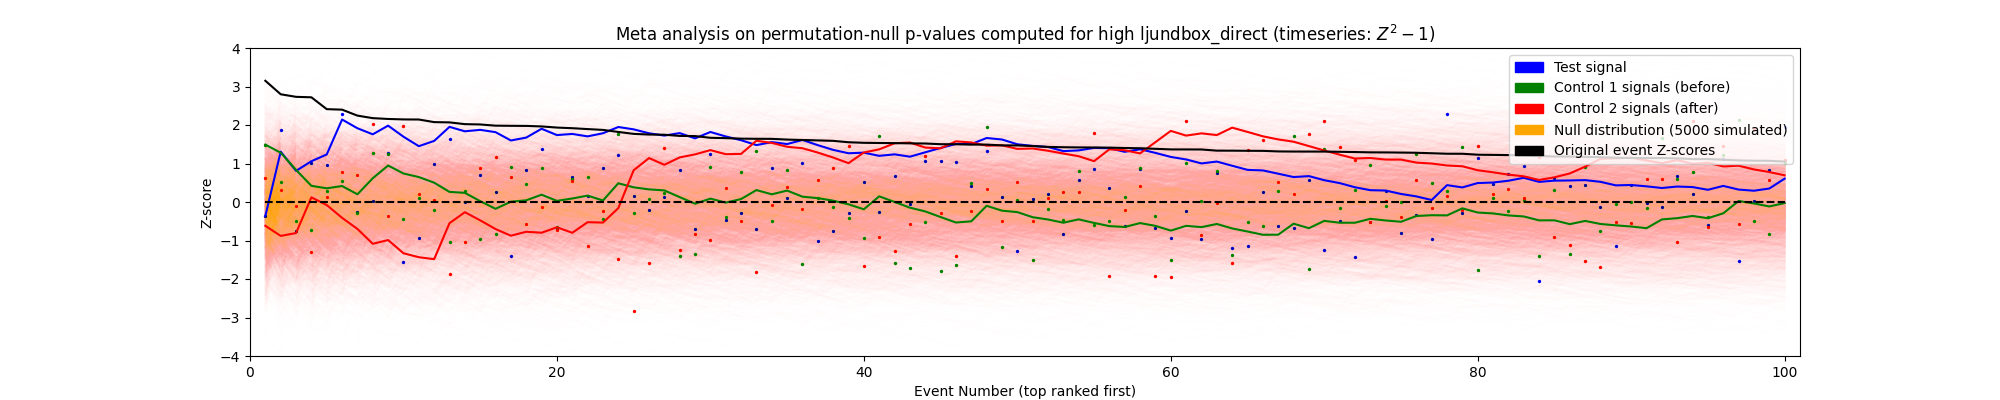

csm1 empirical_ljundbox
Testing for postive z-scores:
test pval: 0.1218
control1 pval: 0.3736
control2 pval: 0.1772
Testing for negative z-scores:
test pval: 0.9012
control1 pval: 0.722
control2 pval: 0.3972


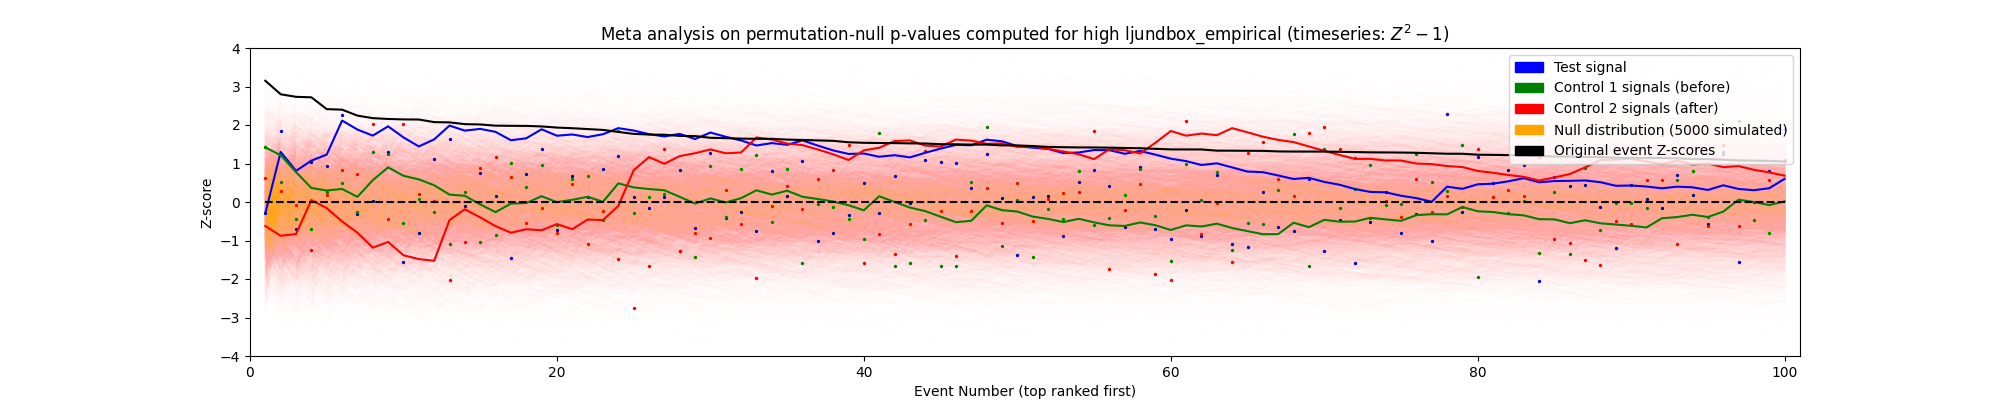

In [ ]:
for signalname, signaldisplayname, pvals in [('csm1', '$Z^2 - 1$', pvals_csm1),
                                             #('covarmetric', 'new covariance metric', pvals_covarmetric),
                                             ]:
  print(signalname)
  for metricname, metricdisplayname in [('direct_ljundbox', 'ljundbox_direct'),
                                        ('empirical_ljundbox', 'ljundbox_empirical')

                                        #('nperseg-NA_ef', 'power-weighted frequency'),
                                        #('nperseg-NA_maxd', 'Max Deviation From Uniform'),
                                        #('nperseg-NA_smooth-p00625', 'power peak (smoothed at f=0.00625)'),
                                        #('nperseg-NA_smooth-p0075', 'power peak (smoothed at f=0.0075)'),
                                        #('nperseg-NA_smooth-p01', 'power peak (smoothed at f=0.01)'),
                                        #('nperseg-NA_smooth-p0125', 'power peak (smoothed at f=0.0125)'),
                                        #('nperseg-NA_smooth-p015', 'power peak (smoothed at f=0.015)'),
                                        #('nperseg-NA_smooth-p02', 'power peak (smoothed at f=0.02)'),
                                        #('nperseg-NA_smooth-p025', 'power peak (smoothed at f=0.025)'),
                                        #('nperseg-NA_smooth-p05', 'power peak (smoothed at f=0.05)')

                                        #('nperseg-NA_ef', 'power-weighted frequency'),
                                        #('nperseg-60min_ef', 'power-weighted frequency (welch=60min)'),
                                        #('nperseg-30min_ef', 'power-weighted frequency (welch=30min)'),
                                        #('nperseg-15min_ef', 'power-weighted frequency (welch=15min)'),
                                        #('nperseg-7.5min_ef', 'power-weighted frequency (welch=7.5min)'),

                                        #('nperseg-NA_maxd', 'Max Deviation From Uniform'),
                                        #('nperseg-60min_maxd', 'Max Deviation From Uniform (welch=60min)'),
                                        #('nperseg-30min_maxd', 'Max Deviation From Uniform (welch=30min)'),
                                        #('nperseg-15min_maxd', 'Max Deviation From Uniform (welch=15min)'),
                                        #('nperseg-7.5min_maxd', 'Max Deviation From Uniform (welch=7.5min)'),

                                        #('nperseg-NA_smooth-p00625', 'power peak (smoothed at f=0.00625)'),
                                        #('nperseg-60min_smooth-p00625', 'power peak (smoothed at f=0.00625, welch=60min)'),
                                        #('nperseg-30min_smooth-p00625', 'power peak (smoothed at f=0.00625, welch=30min)'),
                                        #('nperseg-15min_smooth-p00625', 'power peak (smoothed at f=0.00625, , welch=15min)'),
                                        #('nperseg-7.5min_smooth-p00625', 'power peak (smoothed at f=0.00625, , welch=7.5min)'),

                                        #('nperseg-NA_smooth-p0075', 'power peak (smoothed at f=0.0075)'),
                                        #('nperseg-60min_smooth-p0075', 'power peak (smoothed at f=0.0075, welch=60min)'),
                                        #('nperseg-30min_smooth-p0075', 'power peak (smoothed at f=0.0075, welch=30min)'),
                                        #('nperseg-15min_smooth-p0075', 'power peak (smoothed at f=0.0075, welch=15min)'),
                                        #('nperseg-7.5min_smooth-p0075', 'power peak (smoothed at f=0.0075, welch=7.5min)'),

                                        #('nperseg-NA_smooth-p01', 'power peak (smoothed at f=0.0075)'),
                                        #('nperseg-60min_smooth-p01', 'power peak (smoothed at f=0.0075), welch=60min'),
                                        #('nperseg-30min_smooth-p01', 'power peak (smoothed at f=0.0075), welch=30min'),
                                        #('nperseg-15min_smooth-p01', 'power peak (smoothed at f=0.0075), welch=15min'),
                                        #('nperseg-7.5min_smooth-p01', 'power peak (smoothed at f=0.0075), welch=7.5min'),

                                        #('nperseg-NA_smooth-p0125', 'power peak (smoothed at f=0.0125)'),
                                        #('nperseg-60min_smooth-p0125', 'power peak (smoothed at f=0.0125), welch=60min'),
                                        #('nperseg-30min_smooth-p0125', 'power peak (smoothed at f=0.0125), welch=30min'),
                                        #('nperseg-15min_smooth-p0125', 'power peak (smoothed at f=0.0125), welch=15min'),
                                        #('nperseg-7.5min_smooth-p0125', 'power peak (smoothed at f=0.0125), welch=7.5min'),

                                        #('nperseg-NA_smooth-p015', 'power peak (smoothed at f=0.015)'),
                                        #('nperseg-60min_smooth-p015', 'power peak (smoothed at f=0.015), welch=60min'),
                                        #('nperseg-30min_smooth-p015', 'power peak (smoothed at f=0.015), welch=30min'),
                                        #('nperseg-15min_smooth-p015', 'power peak (smoothed at f=0.015), welch=15min'),
                                        #('nperseg-7.5min_smooth-p015', 'power peak (smoothed at f=0.015), welch=7.5min'),

                                        #('nperseg-NA_smooth-p02', 'power peak (smoothed at f=0.02)'),
                                        #('nperseg-60min_smooth-p02', 'power peak (smoothed at f=0.02), welch=60min'),
                                        #('nperseg-30min_smooth-p02', 'power peak (smoothed at f=0.02), welch=30min'),
                                        #('nperseg-15min_smooth-p02', 'power peak (smoothed at f=0.02), welch=15min'),
                                        #('nperseg-7.5min_smooth-p02', 'power peak (smoothed at f=0.02), welch=7.5min'),

                                        #('nperseg-NA_smooth-p025', 'power peak (smoothed at f=0.025)'),
                                        #('nperseg-60min_smooth-p025', 'power peak (smoothed at f=0.025), welch=60min'),
                                        #('nperseg-30min_smooth-p025', 'power peak (smoothed at f=0.025), welch=30min'),
                                        #('nperseg-15min_smooth-p025', 'power peak (smoothed at f=0.025), welch=15min'),
                                        #('nperseg-7.5min_smooth-p025', 'power peak (smoothed at f=0.025), welch=7.5min'),

                                        #('nperseg-NA_smooth-p05', 'power peak (smoothed at f=0.05)'),
                                        #('nperseg-60min_smooth-p05', 'power peak (smoothed at f=0.05), welch=60min'),
                                        #('nperseg-30min_smooth-p05', 'power peak (smoothed at f=0.05), welch=30min'),
                                        #('nperseg-15min_smooth-p05', 'power peak (smoothed at f=0.05), welch=15min'),
                                        #('nperseg-7.5min_smooth-p05', 'power peak (smoothed at f=0.05), welch=7.5min'),
                                        ]:
    print(signalname,metricname)
    make_meta_trend_plot(
      "Meta analysis on permutation-null p-values computed for high "
        +metricdisplayname+" (timeseries: "+signaldisplayname+")",
      test_pvals=np.array([x["pval_"+metricname] for x in pvals["test"]]),
      control1_pvals=np.array([x["pval_"+metricname] for x in pvals["control1"]]),
      control2_pvals=np.array([x["pval_"+metricname] for x in pvals["control2"]]),
      savefilename=signalname+"_"+metricname)
    display(Image("analysis/metapval_"+signalname+"_"+metricname+".png"))

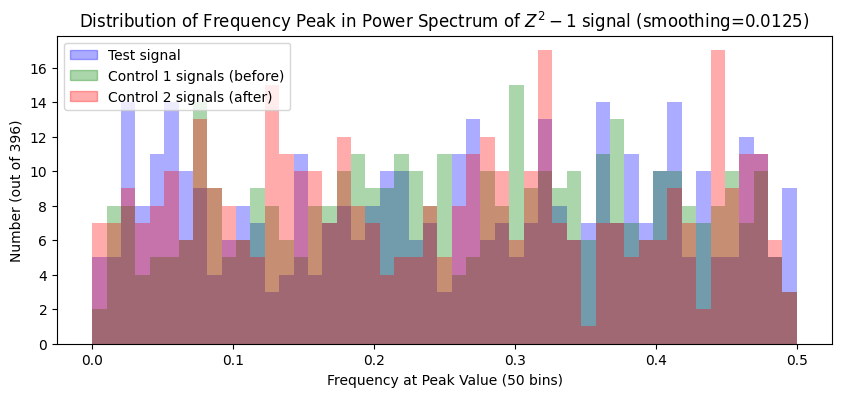

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,4))
_, bins, _ = plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["test"]],
                      bins=np.linspace(0,0.5,50), color="blue", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control1"]],
         bins=np.linspace(0,0.5,50), color="green", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control2"]],
         bins=np.linspace(0,0.5,50), color="red", alpha=0.33)
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal', alpha=0.33),
                    mpatches.Patch(color='green', label='Control 1 signals (before)', alpha=0.33),
                    mpatches.Patch(color='red', label='Control 2 signals (after)', alpha=0.33)],
             loc="upper left")
plt.title("Distribution of Frequency Peak in Power Spectrum of $Z^2 - 1$ signal (smoothing=0.0125)")
plt.xlabel("Frequency at Peak Value (50 bins)")
plt.ylabel("Number (out of "+str(len(pvals_csm1["test"]))+")")
plt.show()